In [ ]:
# Define the gpu on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

import pandas as pd
import json
import numpy as np
import os
from simpletransformers.classification import ClassificationModel
import matplotlib.pyplot as plt
from openai import OpenAI
from tqdm import tqdm
client = OpenAI(api_key=open('key.txt').read())

In [ ]:
# Open the final test sample

test_df = pd.read_json("MaCoCu-manually-annotated-test-set-with-preds.json", orient="records", lines=True)

print(test_df.shape)

test_df.head(3)

In [3]:
def testing(test_df, y_pred_column, model_name="", figure=False):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - y_pred_column: column with predictions
    - test_name
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

    # Get the true labels
    y_true = test_df["IPTC_true"].to_list()
    LABELS = list(test_df["IPTC_true"].unique())
    y_pred = test_df[y_pred_column].to_list()

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}, Accuracy: {accuracy:0.3}")
    
    print(classification_report(y_true, y_pred))
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Get lang specific scores acuracy
    lang_results = {}

    for lang in list(test_df["lang"].unique()):
        current_test_df = test_df[test_df["lang"] == lang]
        current_y_true = current_test_df["IPTC_true"].to_list()
        current_labels = list(current_test_df["IPTC_true"].unique())
        current_y_pred = current_test_df[y_pred_column].to_list()
        cur_macro = f1_score(current_y_true, current_y_pred, labels=current_labels, average="macro")
        cur_micro = f1_score(current_y_true, current_y_pred, labels=current_labels, average="micro")
        cur_accuracy = accuracy_score(current_y_true, current_y_pred)
        lang_results[lang] = {"micro-F1": cur_micro, "macro-F1": cur_macro, "accuracy": cur_accuracy}

    results_acc_df = pd.DataFrame(lang_results)
    print(results_acc_df.transpose().to_markdown())
    
    if figure == True:
        # Plot the confusion matrix:
        cm = confusion_matrix(y_true, y_pred, labels=LABELS)
        plt.figure(figsize=(9, 9))
        plt.imshow(cm, cmap="Oranges")
        for (i, j), z in np.ndenumerate(cm):
            plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
        classNames = LABELS
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        tick_marks = np.arange(len(classNames))
        plt.xticks(tick_marks, classNames, rotation=90)
        plt.yticks(tick_marks, classNames)
        plt.title(f"{model_name}")

        plt.tight_layout()
        fig1 = plt.gcf()
        plt.show()
        plt.draw()
        #fig1.savefig(f"Confusion-matrix-{model_name}.png",dpi=100)
    
    return {"micro-F1": micro, "macro-F1": macro, "accuracy": accuracy, "lang_results": lang_results, "report": report}

# Evaluate models

In [ ]:
# Open the main results file:

previous_results_file = open("results/BERT-model-experiments-results.json")
previous_results = json.load(previous_results_file)
len(previous_results)

In [5]:
results_df = pd.DataFrame(previous_results).transpose().drop(columns=["lang_results", "report"])
results_df.reset_index(names="model", inplace=True)
results_df

,model,micro-F1,macro-F1,accuracy
0,pred_GPT4o,0.719221,0.727549,0.719221
1,pred_GPT4o-v2,0.724535,0.733124,0.724535
2,pred_GPT4o-v3,0.722764,0.732576,0.722764
3,15k-model-sample_2-v1,0.71302,0.725569,0.71302
4,10k-model-sample_2-v1,0.708592,0.720184,0.708592
5,5k-model-sample_2-v1,0.697963,0.706499,0.697963
6,2.5k-model-sample_2-v1,0.696191,0.705976,0.696191
7,1k-model-sample_2-v1,0.681134,0.692653,0.681134
8,1k-model-sample_3-v1,0.677591,0.693941,0.677591
9,2.5k-model-sample_3-v1,0.690877,0.706278,0.690877


In [6]:
print(results_df.sort_values("macro-F1", ascending=False).to_markdown(index=False))

| model                  |   micro-F1 |   macro-F1 |   accuracy |
|:-----------------------|-----------:|-----------:|-----------:|
| 15k-model-sample_redo  |   0.726306 |   0.738468 |   0.726306 |
| pred_GPT4o-v2          |   0.724535 |   0.733124 |   0.724535 |
| pred_GPT4o-v3          |   0.722764 |   0.732576 |   0.722764 |
| pred_20k-model-v3      |   0.718335 |   0.731501 |   0.718335 |
| pred_20k-model-v2      |   0.719221 |   0.73077  |   0.719221 |
| 15k-model-sample_4-v1  |   0.718335 |   0.73009  |   0.718335 |
| 15k-model-sample_5-v1  |   0.715678 |   0.729126 |   0.715678 |
| 20k-model-sample_redo  |   0.717449 |   0.728708 |   0.717449 |
| pred_GPT4o             |   0.719221 |   0.727549 |   0.719221 |
| 10k-model-sample_5-v1  |   0.714792 |   0.72716  |   0.714792 |
| pred_20k-model-v4      |   0.714792 |   0.726153 |   0.714792 |
| 15k-model-sample_2-v1  |   0.71302  |   0.725569 |   0.71302  |
| pred_20k-model-v1      |   0.712135 |   0.725213 |   0.712135 |
| 5k-model

In [7]:
# Add "model type" columns
model_types = []

model_names = results_df.model.to_list()

for name in model_names:
	if "pred_20k" in name:
		current_name = "20k-model-sample"
		model_types.append(current_name)
	elif "pred_GPT4o" not in name:
		current_name = name[:-5]
		model_types.append(current_name)
	else:
		if name == "pred_GPT4o":
			model_types.append(name)
		else:
			current_name = name[:-3]
			model_types.append(current_name)

results_df["model_type"] = model_types

results_df

,model,micro-F1,macro-F1,accuracy,model_type
0,pred_GPT4o,0.719221,0.727549,0.719221,pred_GPT4o
1,pred_GPT4o-v2,0.724535,0.733124,0.724535,pred_GPT4o
2,pred_GPT4o-v3,0.722764,0.732576,0.722764,pred_GPT4o
3,15k-model-sample_2-v1,0.71302,0.725569,0.71302,15k-model-sample
4,10k-model-sample_2-v1,0.708592,0.720184,0.708592,10k-model-sample
5,5k-model-sample_2-v1,0.697963,0.706499,0.697963,5k-model-sample
6,2.5k-model-sample_2-v1,0.696191,0.705976,0.696191,2.5k-model-sample
7,1k-model-sample_2-v1,0.681134,0.692653,0.681134,1k-model-sample
8,1k-model-sample_3-v1,0.677591,0.693941,0.677591,1k-model-sample
9,2.5k-model-sample_3-v1,0.690877,0.706278,0.690877,2.5k-model-sample


In [8]:
results_df["model_type"].value_counts()

model_type
15k-model-sample     5
10k-model-sample     5
5k-model-sample      5
2.5k-model-sample    5
1k-model-sample      5
20k-model-sample     5
pred_GPT4o           3
Name: count, dtype: int64

In [9]:
# Average the results by grouping by model type

# Grouping by 'model_type' and calculating the average scores
average_macro_f1 = results_df.groupby('model_type')['macro-F1'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

# Renaming columns for clarity
average_macro_f1.columns = ['model', 'macro_F1', 'std_macro_f1']

average_micro_f1 = results_df.groupby('model_type')['micro-F1'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

average_micro_f1.columns = ['model', 'micro_F1', 'std_micro_f1']

combined_results = pd.merge(left=average_macro_f1, right=average_micro_f1, on="model")

combined_results

,model,macro_F1,std_macro_f1,micro_F1,std_micro_f1
0,pred_GPT4o,0.731083,0.003073,0.722173,0.002706
1,20k-model-sample,0.728469,0.002762,0.716386,0.002897
2,15k-model-sample,0.727556,0.008683,0.7155,0.008055
3,10k-model-sample,0.72047,0.005262,0.70806,0.005410
4,5k-model-sample,0.715907,0.007649,0.703809,0.007888
5,2.5k-model-sample,0.70752,0.007836,0.694774,0.008556
6,1k-model-sample,0.692015,0.009635,0.678299,0.009609


In [10]:
print(combined_results.to_markdown(index=False))

| model             |   macro_F1 |   std_macro_f1 |   micro_F1 |   std_micro_f1 |
|:------------------|-----------:|---------------:|-----------:|---------------:|
| pred_GPT4o        |   0.731083 |     0.00307282 |   0.722173 |     0.00270598 |
| 20k-model-sample  |   0.728469 |     0.00276209 |   0.716386 |     0.00289733 |
| 15k-model-sample  |   0.727556 |     0.00868345 |   0.7155   |     0.00805488 |
| 10k-model-sample  |   0.72047  |     0.0052617  |   0.70806  |     0.00540954 |
| 5k-model-sample   |   0.715907 |     0.0076491  |   0.703809 |     0.00788756 |
| 2.5k-model-sample |   0.70752  |     0.00783596 |   0.694774 |     0.00855553 |
| 1k-model-sample   |   0.692015 |     0.00963504 |   0.678299 |     0.00960936 |


In [11]:
# Sort the values by data size

# Convert the column to a categorical type with the custom order
combined_results['model'] = pd.Categorical(combined_results['model'], categories=["1k-model-sample", '2.5k-model-sample', '5k-model-sample', '10k-model-sample','15k-model-sample', "20k-model-sample",'pred_GPT4o',], ordered=True)

combined_results.sort_values('model', inplace=True)

combined_results

,model,macro_F1,std_macro_f1,micro_F1,std_micro_f1
6,1k-model-sample,0.692015,0.009635,0.678299,0.009609
5,2.5k-model-sample,0.70752,0.007836,0.694774,0.008556
4,5k-model-sample,0.715907,0.007649,0.703809,0.007888
3,10k-model-sample,0.72047,0.005262,0.70806,0.005410
2,15k-model-sample,0.727556,0.008683,0.7155,0.008055
1,20k-model-sample,0.728469,0.002762,0.716386,0.002897
0,pred_GPT4o,0.731083,0.003073,0.722173,0.002706


In [12]:
# Remove GPT from combined results
combined_results.drop(0, inplace=True)
combined_results

,model,macro_F1,std_macro_f1,micro_F1,std_micro_f1
6,1k-model-sample,0.692015,0.009635,0.678299,0.009609
5,2.5k-model-sample,0.70752,0.007836,0.694774,0.008556
4,5k-model-sample,0.715907,0.007649,0.703809,0.007888
3,10k-model-sample,0.72047,0.005262,0.70806,0.005410
2,15k-model-sample,0.727556,0.008683,0.7155,0.008055
1,20k-model-sample,0.728469,0.002762,0.716386,0.002897


In [13]:
# Rename models

combined_results["model_rename"] = ["1k texts","2.5k texts", "5k texts",  "10k texts", "15k texts", "20k texts"]
combined_results

,model,macro_F1,std_macro_f1,micro_F1,std_micro_f1,model_rename
6,1k-model-sample,0.692015,0.009635,0.678299,0.009609,1k texts
5,2.5k-model-sample,0.70752,0.007836,0.694774,0.008556,2.5k texts
4,5k-model-sample,0.715907,0.007649,0.703809,0.007888,5k texts
3,10k-model-sample,0.72047,0.005262,0.70806,0.005410,10k texts
2,15k-model-sample,0.727556,0.008683,0.7155,0.008055,15k texts
1,20k-model-sample,0.728469,0.002762,0.716386,0.002897,20k texts


/tmp/ipykernel_1183633/3017120567.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha='right')


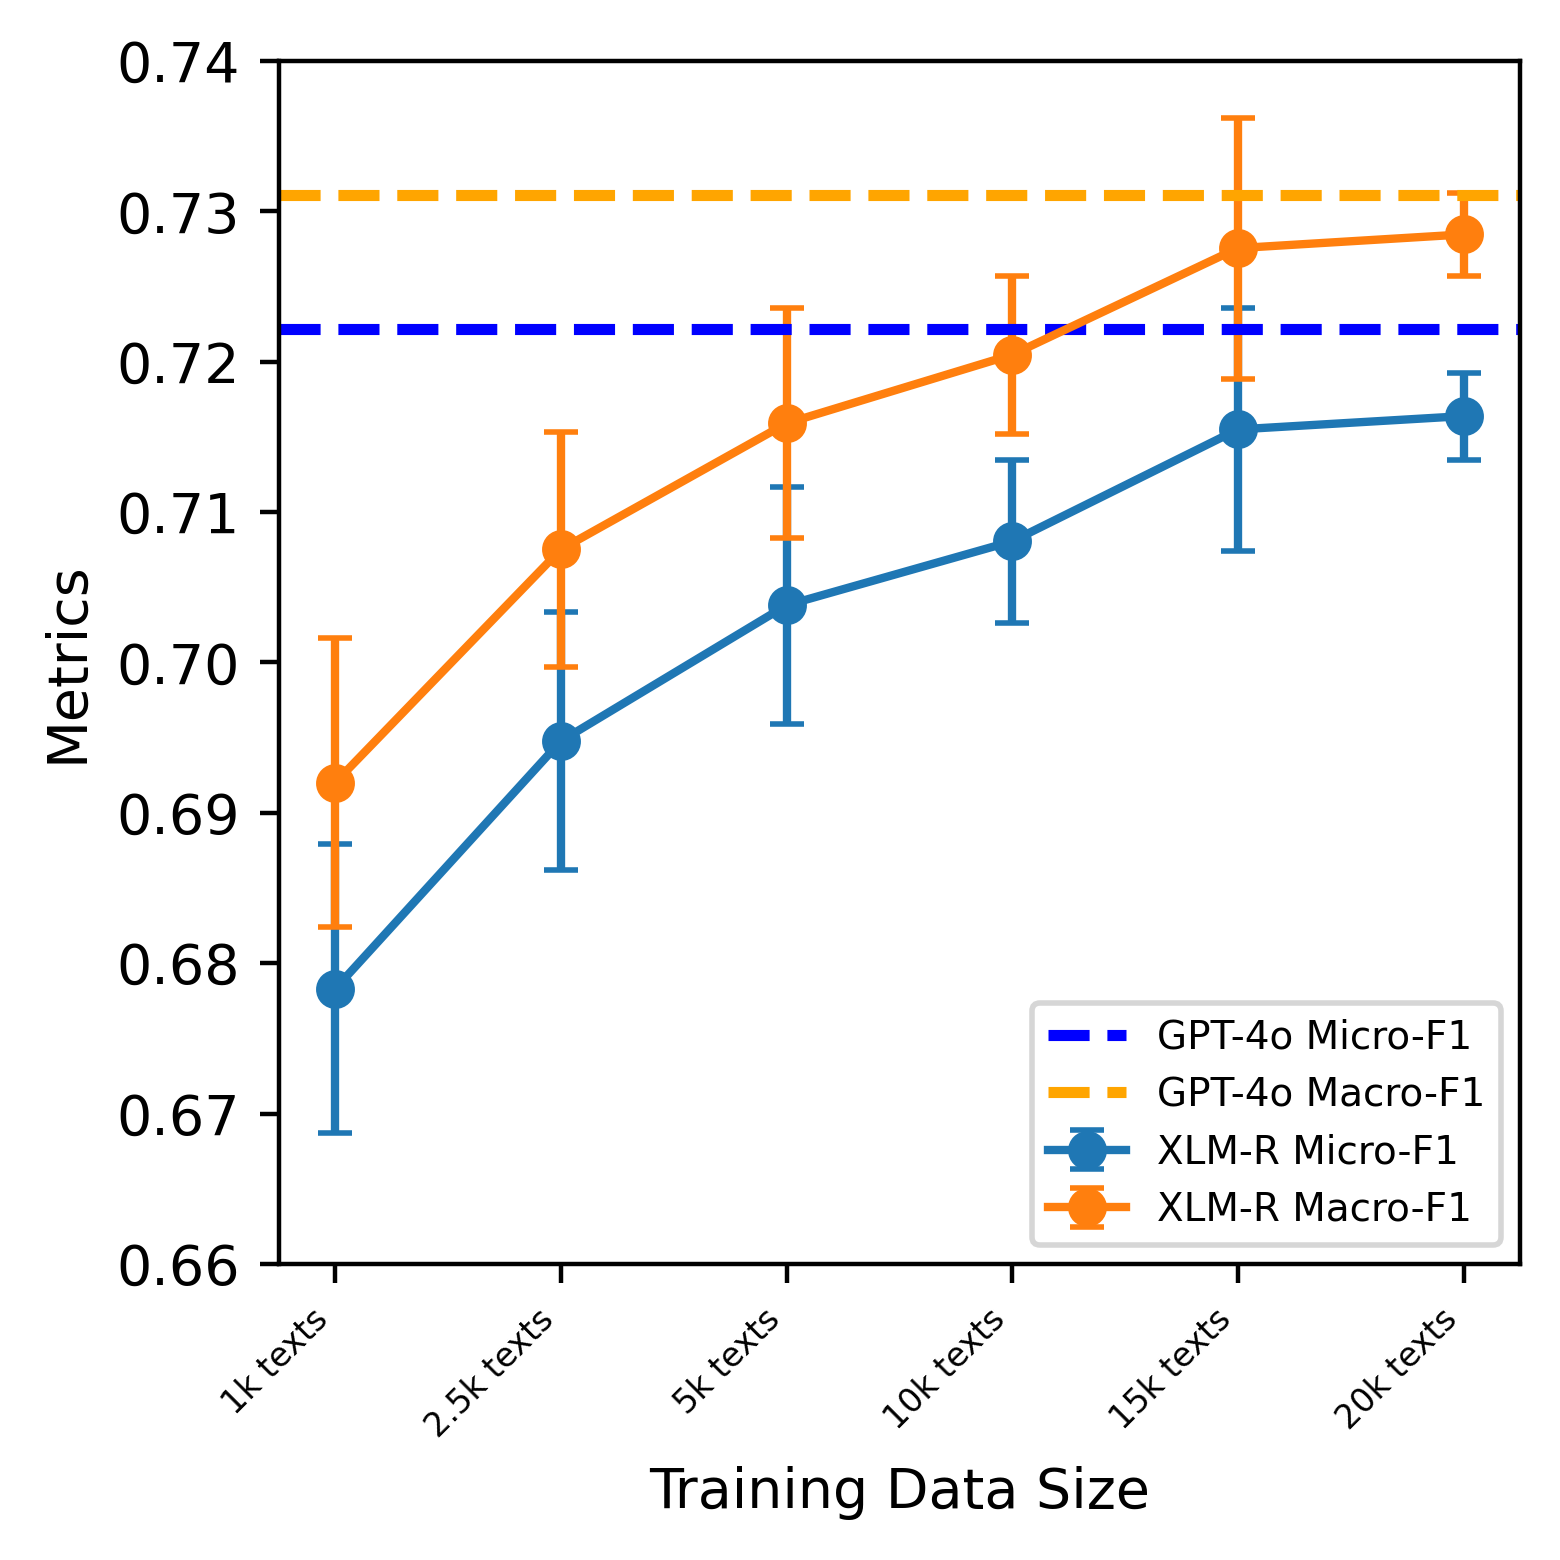

In [ ]:
# Plot the differences between the average macro scores and accuracy for different setups:

setup_of_interest = combined_results["model_rename"].to_list()

average_mi = combined_results["micro_F1"].to_list()
average_mi_std= combined_results["std_micro_f1"].to_list()
average_ma = combined_results["macro_F1"].to_list()
average_ma_std = combined_results["std_macro_f1"].to_list()

fig, ax = plt.subplots(figsize=(4,4), dpi=400)

ax.errorbar(setup_of_interest, average_mi, yerr=average_mi_std, fmt='-o', label="XLM-R Micro-F1", capsize=3)
ax.errorbar(setup_of_interest, average_ma, yerr=average_ma_std, fmt='-o', label="XLM-R Macro-F1", capsize=3)
ax.axhline(y=0.722173, label="GPT-4o Micro-F1", color='blue', linestyle='--', linewidth=2)
ax.axhline(y=0.731083, label="GPT-4o Macro-F1", color='orange', linestyle='--', linewidth=2)


plt.xticks(fontsize=6)
ax.set_xlabel('Training Data Size')
ax.set_ylabel('Metrics')
xlabels = setup_of_interest
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.legend(fontsize=7, loc=4)
ax.set_ylim(0.66, 0.74)
fig.tight_layout()
plt.show()

# Monolingual vs multilingual models


In [4]:
monolingual_models = ['pred_5k-hr-model-v1', 'pred_5k-sl-model-v1', 'pred_5k-ca-model-v1', 'pred_5k-el-model-v1', 'pred_5k-sl-model-v2', 'pred_5k-sl-model-v3', 'pred_5k-ca-model-v2', 'pred_5k-ca-model-v3', 'pred_5k-el-model-v2', 'pred_5k-el-model-v3', 'pred_5k-hr-model-v2', 'pred_5k-hr-model-v3', 'pred_5k-model-v1', 'pred_5k-model-v2', 'pred_5k-model-v3','pred_GPT4o', 'pred_GPT4o-v2', 'pred_GPT4o-v3']

In [ ]:
with open(f"results/BERT-monolingual-model-experiments-results.json", "r") as results_file:
	mono_results = json.load(results_file)

mono_results

{'5k-hr-model-v1-redone': {'micro-F1': 0.6970770593445527,
  'macro-F1': 0.7064997223945171,
  'accuracy': 0.6970770593445527,
  'lang_results': {'hr': {'micro-F1': 0.6804123711340206,
    'macro-F1': 0.6821912607538793,
    'accuracy': 0.6804123711340206},
   'ca': {'micro-F1': 0.6629213483146067,
    'macro-F1': 0.6681699110473177,
    'accuracy': 0.6629213483146067},
   'sl': {'micro-F1': 0.7127659574468085,
    'macro-F1': 0.7190877024933958,
    'accuracy': 0.7127659574468085},
   'el': {'micro-F1': 0.7301038062283737,
    'macro-F1': 0.7337853962529747,
    'accuracy': 0.7301038062283737}},
  'report': {'arts, culture, entertainment and media': {'precision': 0.5882352941176471,
    'recall': 0.78125,
    'f1-score': 0.6711409395973155,
    'support': 64.0},
   'conflict, war and peace': {'precision': 0.6041666666666666,
    'recall': 0.8055555555555556,
    'f1-score': 0.6904761904761905,
    'support': 36.0},
   'crime, law and justice': {'precision': 0.7945205479452054,
    're

In [10]:
results_df = pd.DataFrame(mono_results).transpose().drop(columns=["lang_results", "report"])
results_df.reset_index(names="model", inplace=True)
results_df

,model,micro-F1,macro-F1,accuracy
0,5k-hr-model-v1-redone,0.697077,0.7065,0.697077
1,5k-hr-model-v2-redone,0.712135,0.722685,0.712135
2,5k-hr-model-v3-redone,0.708592,0.719249,0.708592
3,5k-ca-model-v1-redone,0.691763,0.702501,0.691763
4,5k-ca-model-v2-redone,0.697963,0.710602,0.697963
5,5k-ca-model-v3-redone,0.704163,0.717279,0.704163
6,5k-sl-model-v1-redone,0.699734,0.716958,0.699734
7,5k-sl-model-v2-redone,0.70062,0.715311,0.70062
8,5k-sl-model-v3-redone,0.691763,0.707001,0.691763
9,5k-el-model-v1-redone,0.682019,0.690116,0.682019


In [11]:
# Add "model type" columns
model_types = []

model_names = results_df.model.to_list()

for name in model_names:
	if "pred_GPT4o" in name:
		model_types.append("GPT4o")
	elif "pred_5k-model-sample" in name:
		model_types.append("5k-model-multilingual")
	else:
		current_name = name[:-10]
		model_types.append(current_name)

results_df["model_type"] = model_types

results_df.head(2)

,model,micro-F1,macro-F1,accuracy,model_type
0,5k-hr-model-v1-redone,0.697077,0.7065,0.697077,5k-hr-model
1,5k-hr-model-v2-redone,0.712135,0.722685,0.712135,5k-hr-model


In [12]:
results_df["model_type"].value_counts()

model_type
5k-hr-model              3
5k-ca-model              3
5k-sl-model              3
5k-el-model              3
GPT4o                    3
5k-model-multilingual    3
Name: count, dtype: int64

In [ ]:
# Average the results by grouping by model type

# Grouping by 'model_type' and calculating the average scores
average_macro_f1 = results_df.groupby('model_type')['macro-F1'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

# Renaming columns for clarity
average_macro_f1.columns = ['model', 'macro_F1', 'std_macro_f1']

average_macro_f1

,model,macro_F1,std_macro_f1
5,GPT4o,0.731083,0.003073
2,5k-hr-model,0.716144,0.008527
3,5k-model-multilingual,0.714246,0.009453
4,5k-sl-model,0.71309,0.005337
0,5k-ca-model,0.710127,0.007400
1,5k-el-model,0.695351,0.005862


In [15]:
# Evaluate macro-F1 scores for languages

model_names = results_df.model.to_list()

macro_lang_scores = {}
for model in model_names:
	curr_macros = pd.DataFrame(mono_results[model]["lang_results"]).loc["macro-F1"].to_dict()
	macro_lang_scores[model] = curr_macros

lang_df = pd.DataFrame(macro_lang_scores).transpose()
lang_df.reset_index(names="model",inplace=True)
lang_df

,model,hr,ca,sl,el
0,5k-hr-model-v1-redone,0.682191,0.668170,0.719088,0.733785
1,5k-hr-model-v2-redone,0.715412,0.668957,0.731770,0.751304
2,5k-hr-model-v3-redone,0.704823,0.677484,0.747246,0.731172
3,5k-ca-model-v1-redone,0.694064,0.669599,0.725538,0.699126
4,5k-ca-model-v2-redone,0.704619,0.663886,0.725231,0.724804
5,5k-ca-model-v3-redone,0.717909,0.678860,0.734043,0.719783
6,5k-sl-model-v1-redone,0.718724,0.644908,0.743803,0.733610
7,5k-sl-model-v2-redone,0.710146,0.657588,0.743197,0.721609
8,5k-sl-model-v3-redone,0.704981,0.676144,0.719737,0.707232
9,5k-el-model-v1-redone,0.669717,0.649044,0.726018,0.693983


In [16]:
# Add "model type" columns
model_types = []

model_names = lang_df.model.to_list()

for name in model_names:
	if "pred_GPT4o" in name:
		model_types.append("GPT4o")
	elif "pred_5k-model-sample" in name:
		model_types.append("5k-model-multilingual")
	else:
		current_name = name[:-10]
		model_types.append(current_name)

lang_df["model_type"] = model_types

lang_df.head(2)

,model,hr,ca,sl,el,model_type
0,5k-hr-model-v1-redone,0.682191,0.668170,0.719088,0.733785,5k-hr-model
1,5k-hr-model-v2-redone,0.715412,0.668957,0.731770,0.751304,5k-hr-model


In [17]:
lang_df.model_type.value_counts()

model_type
5k-hr-model              3
5k-ca-model              3
5k-sl-model              3
5k-el-model              3
GPT4o                    3
5k-model-multilingual    3
Name: count, dtype: int64

In [ ]:
# Average the results by grouping by model type

average_hr = lang_df.groupby('model_type')['hr'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

average_hr.columns = ['model', 'hr_macro_F1', 'hr_std']

average_ca = lang_df.groupby('model_type')['ca'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

average_ca.columns = ['model', 'ca_macro_F1', 'ca_std']

average_sl = lang_df.groupby('model_type')['sl'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

average_sl.columns = ['model', 'sl_macro_F1', 'sl_std']

average_el = lang_df.groupby('model_type')['el'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

average_el.columns = ['model', 'el_macro_F1', 'el_std']

combined_results = pd.merge(left=average_hr, right=average_ca, on="model")
combined_results = pd.merge(left=combined_results, right=average_sl, on="model")
combined_results = pd.merge(left=combined_results, right=average_el, on="model")

combined_results.round(2)

,model,hr_macro_F1,hr_std,ca_macro_F1,ca_std,sl_macro_F1,sl_std,el_macro_F1,el_std
0,GPT4o,0.721233,0.000894,0.702207,0.001488,0.747600,0.001216,0.737625,0.008533
1,5k-sl-model,0.711284,0.006942,0.659547,0.015710,0.735579,0.013723,0.720817,0.013207
2,5k-model-multilingual,0.706846,0.011220,0.655963,0.023651,0.741299,0.006996,0.728710,0.004144
3,5k-ca-model,0.705531,0.011949,0.670782,0.007557,0.728270,0.005001,0.714571,0.013609
4,5k-hr-model,0.700809,0.016970,0.671537,0.005165,0.732701,0.014102,0.738754,0.010947
5,5k-el-model,0.674150,0.003855,0.662401,0.011567,0.716431,0.011300,0.705732,0.012772


In [23]:
combined_results.round(3)

,model,hr_macro_F1,hr_std,ca_macro_F1,ca_std,sl_macro_F1,sl_std,el_macro_F1,el_std
0,GPT4o,0.721,0.001,0.702,0.001,0.748,0.001,0.738,0.009
1,5k-sl-model,0.711,0.007,0.660,0.016,0.736,0.014,0.721,0.013
2,5k-model-multilingual,0.707,0.011,0.656,0.024,0.741,0.007,0.729,0.004
3,5k-ca-model,0.706,0.012,0.671,0.008,0.728,0.005,0.715,0.014
4,5k-hr-model,0.701,0.017,0.672,0.005,0.733,0.014,0.739,0.011
5,5k-el-model,0.674,0.004,0.662,0.012,0.716,0.011,0.706,0.013


In [30]:
combined_results.round(3).iloc[0].to_dict()

{'model': 'GPT4o',
 'hr_macro_F1': 0.721,
 'hr_std': 0.001,
 'ca_macro_F1': 0.702,
 'ca_std': 0.001,
 'sl_macro_F1': 0.748,
 'sl_std': 0.001,
 'el_macro_F1': 0.738,
 'el_std': 0.009}

In [19]:
print(combined_results.round(3).to_markdown(index=False))

| model                 |   hr_macro_F1 |   hr_std |   ca_macro_F1 |   ca_std |   sl_macro_F1 |   sl_std |   el_macro_F1 |   el_std |
|:----------------------|--------------:|---------:|--------------:|---------:|--------------:|---------:|--------------:|---------:|
| GPT4o                 |         0.721 |    0.001 |         0.702 |    0.001 |         0.748 |    0.001 |         0.738 |    0.009 |
| 5k-sl-model           |         0.711 |    0.007 |         0.66  |    0.016 |         0.736 |    0.014 |         0.721 |    0.013 |
| 5k-model-multilingual |         0.707 |    0.011 |         0.656 |    0.024 |         0.741 |    0.007 |         0.729 |    0.004 |
| 5k-ca-model           |         0.706 |    0.012 |         0.671 |    0.008 |         0.728 |    0.005 |         0.715 |    0.014 |
| 5k-hr-model           |         0.701 |    0.017 |         0.672 |    0.005 |         0.733 |    0.014 |         0.739 |    0.011 |
| 5k-el-model           |         0.674 |    0.004 |         0

In [6]:
# To the same for micro-F1

micro_lang_scores = {}
for model in monolingual_models:
	curr_micros = pd.DataFrame(mono_results[model]["lang_results"]).loc["micro-F1"].to_dict()
	micro_lang_scores[model] = curr_micros

lang_df = pd.DataFrame(micro_lang_scores).transpose()
lang_df.reset_index(names="model",inplace=True)
lang_df

,model,hr,ca,sl,el
0,pred_5k-hr-model-v1,0.701031,0.659176,0.730496,0.737024
1,pred_5k-sl-model-v1,0.694158,0.662921,0.726950,0.692042
2,pred_5k-ca-model-v1,0.694158,0.659176,0.723404,0.702422
3,pred_5k-el-model-v1,0.670103,0.674157,0.687943,0.698962
4,pred_5k-sl-model-v2,0.711340,0.651685,0.741135,0.709343
5,pred_5k-sl-model-v3,0.704467,0.644195,0.719858,0.698962
6,pred_5k-ca-model-v2,0.694158,0.647940,0.726950,0.688581
7,pred_5k-ca-model-v3,0.687285,0.670412,0.726950,0.705882
8,pred_5k-el-model-v2,0.676976,0.644195,0.698582,0.709343
9,pred_5k-el-model-v3,0.673540,0.677903,0.687943,0.705882


In [7]:
# Add "model type" columns
model_types = []

model_names = lang_df.model.to_list()

for name in model_names:
	if name != "pred_GPT4o":
		current_name = name[:-3]
		model_types.append(current_name)
	else:
		model_types.append(name)

lang_df["model_type"] = model_types

lang_df.head(2)

,model,hr,ca,sl,el,model_type
0,pred_5k-hr-model-v1,0.701031,0.659176,0.730496,0.737024,pred_5k-hr-model
1,pred_5k-sl-model-v1,0.694158,0.662921,0.726950,0.692042,pred_5k-sl-model


In [8]:
# Average the results by grouping by model type

average_hr = lang_df.groupby('model_type')['hr'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

average_hr.columns = ['model', 'hr_micro_F1', 'hr_std']

average_ca = lang_df.groupby('model_type')['ca'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

average_ca.columns = ['model', 'ca_micro_F1', 'ca_std']

average_sl = lang_df.groupby('model_type')['sl'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

average_sl.columns = ['model', 'sl_micro_F1', 'sl_std']

average_el = lang_df.groupby('model_type')['el'].agg(['mean', 'std']).reset_index().sort_values(by="mean", ascending=False)

average_el.columns = ['model', 'el_micro_F1', 'el_std']

combined_results = pd.merge(left=average_hr, right=average_ca, on="model")
combined_results = pd.merge(left=combined_results, right=average_sl, on="model")
combined_results = pd.merge(left=combined_results, right=average_el, on="model")

combined_results

,model,hr_micro_F1,hr_std,ca_micro_F1,ca_std,sl_micro_F1,sl_std,el_micro_F1,el_std
0,pred_GPT4o,0.713631,0.001984,0.702871,0.002162,0.741135,0.000000,0.730104,0.009155
1,pred_5k-sl-model,0.703322,0.008648,0.652934,0.009426,0.729314,0.010834,0.700115,0.008708
2,pred_5k-model,0.697595,0.006873,0.700375,0.029252,0.731678,0.012453,0.725490,0.001998
3,pred_5k-hr-model,0.696449,0.003968,0.669164,0.014180,0.724586,0.005417,0.738178,0.001998
4,pred_5k-ca-model,0.691867,0.003968,0.659176,0.011236,0.725768,0.002047,0.698962,0.009155
5,pred_5k-el-model,0.673540,0.003436,0.665418,0.018475,0.691489,0.006142,0.704729,0.005286


In [9]:
print(combined_results.round(3).to_markdown(index=False))

| model            |   hr_micro_F1 |   hr_std |   ca_micro_F1 |   ca_std |   sl_micro_F1 |   sl_std |   el_micro_F1 |   el_std |
|:-----------------|--------------:|---------:|--------------:|---------:|--------------:|---------:|--------------:|---------:|
| pred_GPT4o       |         0.714 |    0.002 |         0.703 |    0.002 |         0.741 |    0     |         0.73  |    0.009 |
| pred_5k-sl-model |         0.703 |    0.009 |         0.653 |    0.009 |         0.729 |    0.011 |         0.7   |    0.009 |
| pred_5k-model    |         0.698 |    0.007 |         0.7   |    0.029 |         0.732 |    0.012 |         0.725 |    0.002 |
| pred_5k-hr-model |         0.696 |    0.004 |         0.669 |    0.014 |         0.725 |    0.005 |         0.738 |    0.002 |
| pred_5k-ca-model |         0.692 |    0.004 |         0.659 |    0.011 |         0.726 |    0.002 |         0.699 |    0.009 |
| pred_5k-el-model |         0.674 |    0.003 |         0.665 |    0.018 |         0.691 |    0.0

# Evaluate additional models

In [4]:
test_df.head(3)

,initial_index,document_id,genre,text,pred_GPT4o,IPTC_true_multilabel,lang,batch,translation,random_pick-0,...,match_5k-el-model-v2,pred_5k-el-model-v3,match_5k-el-model-v3,pred_5k-hr-model-v2,match_5k-hr-model-v2,pred_5k-hr-model-v3,match_5k-hr-model-v3,2nd_annotation_multilabel,2nd_annotation,IPTC_true
0,824,CLASSLA-web.hr.3842863,News,Iza kamere\n\nFilmsku družinu ZAG posjetila je...,"arts, culture, entertainment and media","[arts, culture, entertainment and media]",hr,1st,None,"arts, culture, entertainment and media",...,yes,"arts, culture, entertainment and media",yes,education,no,education,no,no,None,"arts, culture, entertainment and media"
1,1949,CLASSLA-web.hr.4597011,News,Učenici osmih razreda nedavno su u sklopu tere...,education,[education],hr,1st,None,education,...,yes,education,yes,education,yes,education,yes,no,None,education
2,800,CLASSLA-web.hr.4308755,News,Moto 360 – novi detalji\n\nMoto 360 već nekoli...,science and technology,[science and technology],hr,1st,Moto 360 – new details\n\nThe Moto 360 has bee...,science and technology,...,yes,science and technology,yes,science and technology,yes,science and technology,yes,"[economy, business and finance]","economy, business and finance",science and technology


dummy classifier

In [6]:
# Open training df
train_df = pd.read_json("MaCoCu-main-multilingual-predicted-dataset.jsonl", orient="records", lines=True)

train_df.head(2)


,document_id,genre,text,prediction_sample,IPTC_pred,lang,split,20k_sample,15k_sample,10k_sample,5k_sample,2.5k_sample,1k_sample,5k_balanced_sample
0,CLASSLA-web.hr.4163187,News,Osnovna škola Pećine Rijeka\n\nObavijest učeni...,yes,education,hr,dev,no,no,no,no,no,no,no
1,CLASSLA-web.hr.2821678,News,U organizaciji Lige protiv raka Koprivničko-kr...,yes,health,hr,train,yes,no,no,no,no,no,no


In [9]:
train_df = train_df[train_df["split"] == "train"]

train_df.describe()

,document_id,genre,text,prediction_sample,IPTC_pred,lang,split,20k_sample,15k_sample,10k_sample,5k_sample,2.5k_sample,1k_sample,5k_balanced_sample
count,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
unique,20000,1,20000,2,17,4,1,1,2,2,2,2,2,2
top,CLASSLA-web.hr.2821678,News,U organizaciji Lige protiv raka Koprivničko-kr...,yes,sport,hr,train,yes,yes,no,no,no,no,no
freq,1,20000,1,19045,3066,5000,20000,20000,15000,10000,15000,17500,19000,15000


In [17]:
from sklearn.dummy import DummyClassifier

def dummy(train_df, test_df):
    # Create X_train and Y_train parts, used for sci kit learning
    # List of texts in training split
    X_train = list(train_df.text)
    # List of labels in training split
    Y_train = list(train_df["IPTC_pred"])

    # List of texts in test split
    X_test = list(test_df.text)
    # List of labels in test split
    Y_test = list(test_df["IPTC_true"])

    print(len(X_train), len(Y_train), len(X_test), len(Y_test))

    # Create a list of labels
    labels = list(test_df["IPTC_true"].unique())
    print("Labels: {}".format(labels))

    for strategy in ["stratified", "most_frequent"]:
        dummy_mf = DummyClassifier(strategy=strategy)

        # Train the model
        dummy_mf.fit(X_train, Y_train)

        #Get the predictions
        y_pred_mf = dummy_mf.predict(X_test)

        y_pred = list(y_pred_mf)

        test_df[f"dummy_pred_{strategy}"] = y_pred

    return test_df

In [18]:
test_df = dummy(train_df, test_df)

test_df.head(2)

20000 20000 1129 1129
Labels: ['arts, culture, entertainment and media', 'education', 'science and technology', 'crime, law and justice', 'society', 'disaster, accident and emergency incident', 'conflict, war and peace', 'labour', 'sport', 'politics', 'economy, business and finance', 'religion', 'lifestyle and leisure', 'health', 'environment', 'human interest', 'weather']


,initial_index,document_id,genre,text,pred_GPT4o,IPTC_true_multilabel,lang,batch,translation,random_pick-0,...,match_5k-el-model-v3,pred_5k-hr-model-v2,match_5k-hr-model-v2,pred_5k-hr-model-v3,match_5k-hr-model-v3,2nd_annotation_multilabel,2nd_annotation,IPTC_true,dummy_pred_stratified,dummy_pred_most_frequent
0,824,CLASSLA-web.hr.3842863,News,Iza kamere\n\nFilmsku družinu ZAG posjetila je...,"arts, culture, entertainment and media","[arts, culture, entertainment and media]",hr,1st,None,"arts, culture, entertainment and media",...,yes,education,no,education,no,no,None,"arts, culture, entertainment and media","arts, culture, entertainment and media",sport
1,1949,CLASSLA-web.hr.4597011,News,Učenici osmih razreda nedavno su u sklopu tere...,education,[education],hr,1st,None,education,...,yes,education,yes,education,yes,no,None,education,"arts, culture, entertainment and media",sport


In [19]:
add_results = {}

In [ ]:
for strategy in ["stratified", "most_frequent"]:
	add_results[f"dummy-{strategy}"] = testing(test_df, f"dummy_pred_{strategy}")

In [22]:
pd.DataFrame(add_results)

,dummy-stratified,dummy-most_frequent
micro-F1,0.053144,0.055802
macro-F1,0.041093,0.006218
accuracy,0.053144,0.055802
lang_results,"{'hr': {'micro-F1': 0.061855670103092786, 'mac...","{'hr': {'micro-F1': 0.058419243986254296, 'mac..."
report,"{'arts, culture, entertainment and media': {'p...","{'arts, culture, entertainment and media': {'p..."


# Evaluate published model

In [4]:
from transformers import pipeline

# Load a multi-class classification pipeline - if the model runs on CPU, comment out "device"
classifier = pipeline("text-classification", model="classla/multilingual-IPTC-news-topic-classifier", device=0, max_length=512, truncation=True)

# Example texts to classify
texts = [
    """Slovenian handball team makes it to Paris Olympics semifinal Lille, 8 August - Slovenia defeated Norway 33:28 in the Olympic men's handball tournament in Lille late on Wednesday to advance to the semifinal where they will face Denmark on Friday evening. This is the best result the team has so far achieved at the Olympic Games and one of the best performances in the history of Slovenia's team sports squads.""",
    """Moment dog sparks house fire after chewing power bank An indoor monitoring camera shows the moment a dog unintentionally caused a house fire after chewing on a portable lithium-ion battery power bank. In the video released by Tulsa Fire Department in Oklahoma, two dogs and a cat can be seen in the living room before a spark started the fire that spread within minutes. Tulsa Fire Department public information officer Andy Little said the pets escaped through a dog door, and according to local media the family was also evacuated safely. "Had there not been a dog door, they very well could have passed away," he told CBS affiliate KOTV."""]

# Classify the texts
results = classifier(texts)

# Output the results
for result in results:
    print(result)

## Output
## {'label': 'sport', 'score': 0.9985264539718628}
## {'label': 'disaster, accident and emergency incident', 'score': 0.9957459568977356}


{'label': 'sport', 'score': 0.9985264539718628}
{'label': 'disaster, accident and emergency incident', 'score': 0.9957459568977356}


In [5]:
test_df.head(2)

,initial_index,document_id,genre,text,pred_GPT4o,IPTC_true_multilabel,lang,batch,translation,random_pick-0,...,match_5k-el-model-v2,pred_5k-el-model-v3,match_5k-el-model-v3,pred_5k-hr-model-v2,match_5k-hr-model-v2,pred_5k-hr-model-v3,match_5k-hr-model-v3,2nd_annotation_multilabel,2nd_annotation,IPTC_true
0,824,CLASSLA-web.hr.3842863,News,Iza kamere\n\nFilmsku družinu ZAG posjetila je...,"arts, culture, entertainment and media","[arts, culture, entertainment and media]",hr,1st,None,"arts, culture, entertainment and media",...,yes,"arts, culture, entertainment and media",yes,education,no,education,no,no,None,"arts, culture, entertainment and media"
1,1949,CLASSLA-web.hr.4597011,News,Učenici osmih razreda nedavno su u sklopu tere...,education,[education],hr,1st,None,education,...,yes,education,yes,education,yes,education,yes,no,None,education


In [6]:
texts = test_df.text.to_list()

# Classify the texts
results = classifier(texts)

y_pred = []
conf = []

# Output the results
for result in results:
    y_pred.append(result["label"])
    conf.append(result["score"])

test_df["pred_published_model"] = y_pred
test_df["conf_published_model"] = conf

In [7]:
test_df.head(2)

,initial_index,document_id,genre,text,pred_GPT4o,IPTC_true_multilabel,lang,batch,translation,random_pick-0,...,match_5k-el-model-v3,pred_5k-hr-model-v2,match_5k-hr-model-v2,pred_5k-hr-model-v3,match_5k-hr-model-v3,2nd_annotation_multilabel,2nd_annotation,IPTC_true,pred_published_model,conf_published_model
0,824,CLASSLA-web.hr.3842863,News,Iza kamere\n\nFilmsku družinu ZAG posjetila je...,"arts, culture, entertainment and media","[arts, culture, entertainment and media]",hr,1st,None,"arts, culture, entertainment and media",...,yes,education,no,education,no,no,None,"arts, culture, entertainment and media","arts, culture, entertainment and media",0.932738
1,1949,CLASSLA-web.hr.4597011,News,Učenici osmih razreda nedavno su u sklopu tere...,education,[education],hr,1st,None,education,...,yes,education,yes,education,yes,no,None,education,education,0.981976


In [8]:
test_df["conf_published_model"].describe()

count    1129.000000
mean        0.927164
std         0.130192
min         0.274200
25%         0.942534
50%         0.988220
75%         0.996253
max         0.998824
Name: conf_published_model, dtype: float64

In [9]:
results = testing(test_df, "pred_published_model")

Macro f1: 0.745, Micro f1: 0.733, Accuracy: 0.733
                                           precision    recall  f1-score   support

   arts, culture, entertainment and media       0.60      0.88      0.71        64
                  conflict, war and peace       0.61      0.92      0.73        36
                   crime, law and justice       0.86      0.81      0.84        69
disaster, accident and emergency incident       0.69      0.89      0.78        53
            economy, business and finance       0.78      0.51      0.62       118
                                education       0.85      0.74      0.79        68
                              environment       0.59      0.75      0.66        57
                                   health       0.80      0.80      0.80        59
                           human interest       0.55      0.67      0.61        55
                                   labour       0.86      0.83      0.84        71
                    lifestyle and le

In [11]:
results

{'micro-F1': 0.733392382639504,
 'macro-F1': 0.7446334670083061,
 'accuracy': 0.733392382639504,
 'lang_results': {'hr': {'micro-F1': 0.7285223367697594,
   'macro-F1': 0.7337250724282774,
   'accuracy': 0.7285223367697594},
  'ca': {'micro-F1': 0.7153558052434457,
   'macro-F1': 0.7223041816918032,
   'accuracy': 0.7153558052434457},
  'sl': {'micro-F1': 0.7588652482269503,
   'macro-F1': 0.7647838411831659,
   'accuracy': 0.7588652482269503},
  'el': {'micro-F1': 0.7301038062283737,
   'macro-F1': 0.7420989350503879,
   'accuracy': 0.7301038062283737}},
 'report': {'arts, culture, entertainment and media': {'precision': 0.6021505376344086,
   'recall': 0.875,
   'f1-score': 0.7133757961783439,
   'support': 64.0},
  'conflict, war and peace': {'precision': 0.6111111111111112,
   'recall': 0.9166666666666666,
   'f1-score': 0.7333333333333333,
   'support': 36.0},
  'crime, law and justice': {'precision': 0.8615384615384616,
   'recall': 0.8115942028985508,
   'f1-score': 0.8358208955

In [18]:
print(pd.DataFrame(results["report"]).transpose().round(3).to_markdown())

|                                           |   precision |   recall |   f1-score |   support |
|:------------------------------------------|------------:|---------:|-----------:|----------:|
| arts, culture, entertainment and media    |       0.602 |    0.875 |      0.713 |    64     |
| conflict, war and peace                   |       0.611 |    0.917 |      0.733 |    36     |
| crime, law and justice                    |       0.862 |    0.812 |      0.836 |    69     |
| disaster, accident and emergency incident |       0.691 |    0.887 |      0.777 |    53     |
| economy, business and finance             |       0.779 |    0.508 |      0.615 |   118     |
| education                                 |       0.847 |    0.735 |      0.787 |    68     |
| environment                               |       0.589 |    0.754 |      0.662 |    57     |
| health                                    |       0.797 |    0.797 |      0.797 |    59     |
| human interest                        

In [22]:
results_filtered = testing(test_df[test_df["conf_published_model"] >= 0.90], "pred_published_model")

Macro f1: 0.802, Micro f1: 0.798, Accuracy: 0.798
                                           precision    recall  f1-score   support

   arts, culture, entertainment and media       0.68      0.92      0.78        52
                  conflict, war and peace       0.77      0.94      0.85        32
                   crime, law and justice       0.91      0.88      0.90        60
disaster, accident and emergency incident       0.77      0.90      0.83        49
            economy, business and finance       0.83      0.56      0.67        93
                                education       0.88      0.80      0.84        56
                              environment       0.62      0.88      0.73        42
                                   health       0.93      0.89      0.91        46
                           human interest       0.69      0.75      0.72        44
                                   labour       0.85      0.86      0.85        58
                    lifestyle and le